In [28]:
import os
import numpy as np 
import pandas as pd
import pickle
# plotting 
import matplotlib.pyplot as plt 
# gaussian process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
# utils 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.utils import resample
# dataset
from dataset import Dataset
# metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from datetime import datetime

RAND_ST = 26
__notebook_path__ = os.getcwd()

def make_timestamp() -> str:
    now = datetime.now()
    return now.strftime("%m%d%Y-%H:%M")

# Upload data

In [33]:
#dataset_path = f'{__notebook_path__}/envs_r4_h0.005_f0.1+test'
dataset_path = f'{__notebook_path__}/envs_r4_f0.1_Hopt'

store_model_path = f'{__notebook_path__}/model'
t_threshold = 0.04 # transfer integral threshold in eV

dataset_pd = Dataset(dataset_path).items
# split dataset into parts with low and large hoppings
dataset_pd_higt = dataset_pd.loc[dataset_pd['hval'] >= t_threshold]
dataset_pd_lowt = dataset_pd.loc[dataset_pd['hval'] < t_threshold]
print(f"Total # of small hopp: {dataset_pd_lowt.shape}, large hopp: {dataset_pd_higt.shape}")

# number of dataset items with high hopping 
n_higt = dataset_pd_higt.shape[0]
# number of dataset items with low hopping 
n_lowt = dataset_pd_lowt.shape[0]
# select the same number of dataset items with low hopping as for high hopping
indices_to_select_lowt = np.random.choice(np.arange(n_lowt, dtype=int), int(n_higt)).tolist()
dataset_pd_lowt = dataset_pd_lowt.iloc[indices_to_select_lowt]

dataset_pd_concat = pd.concat([dataset_pd_lowt, dataset_pd_higt])

X_lowt = dataset_pd_lowt.to_numpy()[:,3:].astype(float)
Y_lowt = dataset_pd_lowt.to_numpy()[:,1].astype(float).reshape(-1,1)
X_hight = dataset_pd_higt.to_numpy()[:,3:].astype(float)
Y_hight = dataset_pd_higt.to_numpy()[:,1].astype(float).reshape(-1,1)

X_lowt_train, X_lowt_test, Y_lowt_train, Y_lowt_test = train_test_split(X_lowt, Y_lowt, test_size=0.2, random_state=RAND_ST)
X_hight_train, X_hight_test, Y_hight_train, Y_hight_test = train_test_split(X_hight, Y_hight, test_size=0.2, random_state=RAND_ST)

X_train = np.concatenate((X_lowt_train, X_hight_train), axis=0)
X_test = np.concatenate((X_lowt_test, X_hight_test), axis=0)
Y_train = np.concatenate((Y_lowt_train, Y_hight_train), axis=0)
Y_test = np.concatenate((Y_lowt_test, Y_hight_test), axis=0)

# get numpy entities 
X = dataset_pd_concat.to_numpy()[:,3:].astype(float)
Y = dataset_pd_concat.to_numpy()[:,1].astype(float).reshape(-1,1)
n, p = X.shape

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RAND_ST)

print(f"# small hopp: {dataset_pd_lowt.shape}, large hopp: {dataset_pd_higt.shape}")
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(np.min(Y), np.max(Y))
print(np.min(Y_test), np.max(Y_test))

Total # of small hopp: (1331, 186), large hopp: (480, 186)
# small hopp: (480, 186), large hopp: (480, 186)
(960, 183)
(768, 183)
(192, 183)
0.005004 0.522831
0.005061 0.38831


In [34]:
print(X_train[0].shape)

(183,)


# Neural Network

In [35]:
def plot_history(histories):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 5), sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        ax.plot(histories[i].history['loss'])
        ax.set_xlabel('Epoch')
    
    last_loss = [_.history['loss'][-1] for _ in histories]
    print(last_loss)

    plt.show()

def evaluate_estimator(estimator, X_test, Y_test, X_train, Y_train, save_plot):
    y_pred = estimator.predict(X_test)
    Y_pred = y_pred.mean(axis=1)

    Y_pred_train = estimator.predict(X_train).mean(axis=1)

    # calculate metrics 
    rmse_test = mean_squared_error(Y_test, Y_pred, squared=False)
    mae_test  = mean_absolute_error(Y_test, Y_pred)
    r2_test   = r2_score(Y_test, Y_pred)

    rmse_train = mean_squared_error(Y_train, Y_pred_train, squared=False)
    mae_train  = mean_absolute_error(Y_train, Y_pred_train)
    r2_train   = r2_score(Y_train, Y_pred_train)

    fig, ax  = plt.subplots(1, 1)
    # plot
    ax.scatter(Y_train, Y_pred_train, label='Train')
    ax.scatter(Y_test, Y_pred, label='Test')
    ax.plot([-0.05, 1], [-0.05, 1], '--r')
    ax.set_xlim([-0.05, 0.6])
    ax.set_ylim([-0.05, 0.6])
    ax.set_xlabel('Calculated t_{ij}, eV')
    ax.set_ylabel('Predicted t_{ij}, eV')
    ax.legend()
    ax.set_title(f'Test: R2={r2_test:.3f}, RMSE={rmse_test:.3f}, MAE={mae_test:.3f}\nTrain: R2={r2_train:.3f}, RMSE={rmse_train:.3f}, MAE={mae_train:.3f}')
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable='box')

    timestamp = make_timestamp()
    if save_plot:
        np.savetxt(
            f"eval_results/random_split_100_estimators_{timestamp}_test.csv", 
            np.column_stack((
                            Y_test, 
                            Y_pred, 
                            )),
            header="Y_test,Y_test_pred",
            delimiter=','
        )
        np.savetxt(
            f"eval_results/random_split_100_estimators_{timestamp}_train.csv", 
            np.column_stack((
                            Y_train, 
                            Y_pred_train, 
                            )),
            header="Y_train,Y_train_pred",
            delimiter=','
        )

    plt.show()
    

In [36]:
DROPOUT_RATE = 0.05
LEARN_RATE = 0.001
NUM_FEATURES = 183

In [37]:
def apply_bn_and_dropout(x):
    return layers.Dropout(DROPOUT_RATE)(layers.BatchNormalization()(x))

In [38]:
def make_ann():
    # ANN for prediction of hooping
    input = keras.Input(shape=(NUM_FEATURES,))
    x = layers.Dense(256, activation='relu')(input)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(128, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(64, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    x = layers.Dense(32, activation='relu')(x)
    x = apply_bn_and_dropout(x)
    out = layers.Dense(1, name="affinity")(x)
    ann = keras.Model(input, out, name="t_predictor")
    ann.summary()
    return ann


In [39]:
class EnsembleANN:
    def __init__(self, X, Y, n_estimators=100):
        self.n_estimators = n_estimators
        self.X = X
        self.Y = Y
        self.models = []
        self.histories = []
        self.scalersX = []
    
    def train_ensamble(self):
        for _ in range(self.n_estimators):
            train_ix = resample(list(range(len(self.X))))
            X_train, Y_train = self.X[train_ix], self.Y[train_ix]

            scaler_X = MinMaxScaler().fit(X_train)
            #X_train = scaler_X.transform(X_train)
            self.scalersX.append(scaler_X)

            t_ann = make_ann()
            t_ann.compile(
                optimizer=keras.optimizers.legacy.Adam(LEARN_RATE), 
                loss=keras.losses.MeanSquaredError())
            t_hist = t_ann.fit(
                X_train, 
                Y_train, 
                epochs=2000, 
                batch_size=256,
                verbose=0
            ) 
            
            self.models.append(t_ann)
            self.histories.append(t_hist)
    
    def predict(self, X):
        n = X.shape[0]
        models_pred = np.zeros((n, self.n_estimators))
        
        for i, model in enumerate(self.models):
            #X = self.scalersX[i].transform(X)
            y_pred = np.abs(model.predict(X))
            models_pred[:, i] = y_pred[:, 0]
        
        return models_pred
    
    def save_estimators(self, path_to_save):
        for i, model in enumerate(self.models):
            model.save(f'{path_to_save}/{i}.keras')

    def load_estimators(self, path_to_load):
        if len(self.models) == 0:
            for i in range(self.n_estimators):
                # load model 
                t_model = keras.models.load_model(f'{path_to_load}/{i}.keras')
                self.models.append(t_model)
        else:
            print('Estimators are trained.')


In [40]:
meta_ann = EnsembleANN(X_train, Y_train, n_estimators=100)
meta_ann.train_ensamble()

Model: "t_predictor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_101 (InputLayer)      [(None, 183)]             0         
                                                                 
 dense_400 (Dense)           (None, 256)               47104     
                                                                 
 batch_normalization_400 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_400 (Dropout)       (None, 256)               0         
                                                                 
 dense_401 (Dense)           (None, 128)               32896     
                                                                 
 batch_normalization_401 (Ba  (None, 128)              512       
 tchNormalization)                                     

[0.0002528639743104577, 0.0002835902851074934, 0.00030278810299932957, 0.0003058711008634418, 0.0003481766616459936, 0.00032720674062147737, 0.00020403652160894126, 0.0003145634545944631, 0.00023914684425108135, 0.0003081898030359298, 0.00026357645401731133, 0.0003275644558016211, 0.00019935410819016397, 0.0002393400645814836, 0.00036329127033241093, 0.0002432478650007397, 0.0003372254432179034, 0.0003510457754600793, 0.00026024325052276254, 0.0002072561183013022, 0.00021124699560459703, 0.0002759447961580008, 0.00017755187582224607, 0.0003113484417553991, 0.00023806393437553197, 0.0003661787195596844, 0.00031130952993407845, 0.000292573357000947, 0.00023913462064228952, 0.00024782819673419, 0.00024168739037122577, 0.00031058682361617684, 0.0002982966834679246, 0.00028568037669174373, 0.0003753822820726782, 0.00025137190823443234, 0.0002968435001093894, 0.0004525237891357392, 0.0002970079076476395, 0.0003695480991154909, 0.0003214293101336807, 0.0002895953366532922, 0.00017571312491782

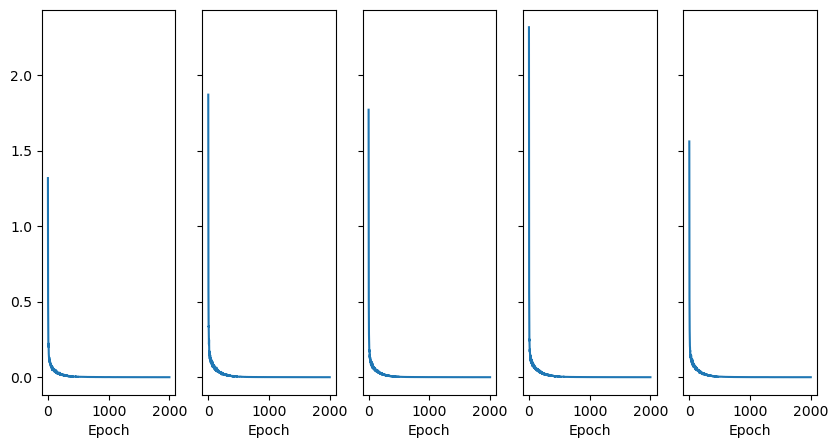

In [22]:
plot_history(meta_ann.histories)

21/21 [==============================] - 0s 630us/step


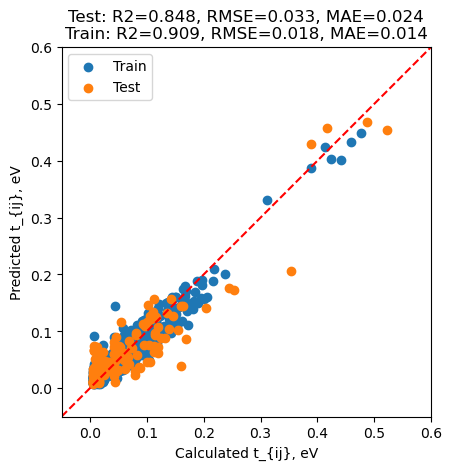

In [27]:
evaluate_estimator(meta_ann, X_test, Y_test, X_train, Y_train, save_plot=True)

In [ ]:
path_to_save = 'model/estimators/'
meta_ann.save_estimators(path_to_save)

In [ ]:
meta_ann_load = EnsembleANN(X_train, Y_train, n_estimators=25)
meta_ann_load.load_estimators(path_to_save)

print(len(meta_ann_load.models))

In [ ]:
evaluate_estimator(meta_ann_load, X_test, Y_test, X_train, Y_train)

# k-Fold Cross-Validation

In [409]:
res_lir = {'r2': [], 'rmse': [], 'mae': []}
res_rfr = {'r2': [], 'rmse': [], 'mae': []}
res_gpr = {'r2': [], 'rmse': [], 'mae': []}
res_ann = {'r2': [], 'rmse': [], 'mae': []}
res_ann_en = {'r2': [], 'rmse': [], 'mae': []}

kf = KFold(n_splits=6, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, Y_train = X[train_index], Y[train_index]
    X_test, Y_test = X[test_index], Y[test_index]

    # LINEAR REGRESSION
    lir = LinearRegression().fit(X_train, Y_train)
    Y_lir = lir.predict(X_test)
    res_lir['r2'].append(r2_score(Y_test, Y_lir))
    res_lir['rmse'].append(mean_squared_error(Y_test, Y_lir, squared=False))
    res_lir['mae'].append(mean_absolute_error(Y_test, Y_lir))

    # RANDOM FOREST 
    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=300, 
        max_features='sqrt',
        random_state=RAND_ST
    ).fit(X_train, Y_train.ravel())
    Y_rfr = rfr.predict(X_test)
    res_rfr['r2'].append(r2_score(Y_test, Y_rfr))
    res_rfr['rmse'].append(mean_squared_error(Y_test, Y_rfr, squared=False))
    res_rfr['mae'].append(mean_absolute_error(Y_test, Y_rfr))

    # GAUSSIAN PROCESS REGRESSION
    kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * NUM_FEATURES, length_scale_bounds=(1e-36, 1e36), nu=2.0)
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.005, 
        n_restarts_optimizer=500,
        random_state=RAND_ST
    ).fit(X_train, Y_train)
    Y_gpr = gpr.predict(X_test)
    res_gpr['r2'].append(r2_score(Y_test, Y_gpr))
    res_gpr['rmse'].append(mean_squared_error(Y_test, Y_gpr, squared=False))
    res_gpr['mae'].append(mean_absolute_error(Y_test, Y_gpr))

    # ARTIFICIAL NEURAL NETWORK 
    ann = make_ann()
    ann.compile(
        optimizer=keras.optimizers.legacy.Adam(LEARN_RATE), 
        loss=keras.losses.MeanSquaredError())
    ann.fit(
        X_train, 
        Y_train, 
        epochs=2000, 
        batch_size=256,
        verbose=0
    ) 
    Y_ann = ann.predict(X_test)
    res_ann['r2'].append(r2_score(Y_test, Y_ann))
    res_ann['rmse'].append(mean_squared_error(Y_test, Y_ann, squared=False))
    res_ann['mae'].append(mean_absolute_error(Y_test, Y_ann))

    # ENSEMBLE ARTIFICIAL NEURAL NETWORK
    # ann_en = EnsembleANN(X_train, Y_train, n_estimators=100)
    # ann_en.train_ensamble()
    # Y_ann_en = ann_en.predict(X_test)
    # res_ann_en['r2'].append(r2_score(Y_test, Y_ann_en))
    # res_ann_en['rmse'].append(mean_squared_error(Y_test, Y_ann_en, squared=False))
    # res_ann_en['mae'].append(mean_absolute_error(Y_test, Y_ann_en))

    print(f'Completed fold: {i}')
    

In [411]:
res_lir_pd = pd.DataFrame(data=res_lir)
res_rfr_pd = pd.DataFrame(data=res_rfr)
res_gpr_pd = pd.DataFrame(data=res_gpr)
res_ann_pd = pd.DataFrame(data=res_ann)

In [413]:
print(f"LIR: R2={res_lir_pd['r2'].mean():.3f}({res_lir_pd['r2'].std():.3f}), RMSE={res_lir_pd['rmse'].mean():.3f}({res_lir_pd['rmse'].std():.3f}), MSE={res_lir_pd['mae'].mean():.3f}({res_lir_pd['mae'].std():.3f})")
print(f"RFR: R2={res_rfr_pd['r2'].mean():.3f}({res_rfr_pd['r2'].std():.3f}), RMSE={res_rfr_pd['rmse'].mean():.3f}({res_rfr_pd['rmse'].std():.3f}), MSE={res_rfr_pd['mae'].mean():.3f}({res_rfr_pd['mae'].std():.3f})")
print(f"GPR: R2={res_gpr_pd['r2'].mean():.3f}({res_gpr_pd['r2'].std():.3f}), RMSE={res_gpr_pd['rmse'].mean():.3f}({res_gpr_pd['rmse'].std():.3f}), MSE={res_gpr_pd['mae'].mean():.3f}({res_gpr_pd['mae'].std():.3f})")
print(f"ANN: R2={res_ann_pd['r2'].mean():.3f}({res_ann_pd['r2'].std():.3f}), RMSE={res_ann_pd['rmse'].mean():.3f}({res_ann_pd['rmse'].std():.3f}), MSE={res_ann_pd['mae'].mean():.3f}({res_ann_pd['mae'].std():.3f})")

LIR: R2=0.252(0.190), RMSE=0.059(0.005), MSE=0.045(0.004)
LIR: R2=0.579(0.096), RMSE=0.045(0.006), MSE=0.031(0.004)


In [404]:
res_lir_pd.to_csv('eval_results/lir_6fold_cv.csv')
res_rfr_pd.to_csv('eval_results/rfr_6fold_cv.csv')
res_gpr_pd.to_csv('eval_results/gpr_6fold_cv.csv')
res_ann_pd.to_csv('eval_results/ann_6fold_cv.csv')

# Evaluation of GPR 

In [ ]:
def plot_model_eval(Y_test, Y_pred, Y_pred_std=None):
    # metrics
    rmse = mean_squared_error(Y_pred, Y_test, squared=False)
    mae  = mean_absolute_error(Y_pred, Y_test)
    r2   = r2_score(Y_pred, Y_test)
    
    fig, ax = plt.subplots(figsize=(6, 6)) 

    plt.plot(np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1), color='red')

    if type(Y_pred_std) == np.ndarray:
        plt.errorbar(Y_test.flatten(), Y_pred.flatten(), Y_pred_std.flatten(), capsize=10, marker='o', ls='none')
    else:
        plt.scatter(Y_test.flatten(), Y_pred.flatten())
       
        
    plt.xlim([-0.05, 0.6])
    plt.ylim([-0.05, 0.6])
    plt.xlabel('Target')
    plt.ylabel('Prediction')
    plt.title(f'R2={r2:.3f}, RMSE={rmse:.3f}, MAE={mae:.3f}')
    plt.show()

def validate_model(X_train, X_test, Y_train, Y_test, nu=2.0, show_plot=True, save_plot=False):
    """
    Perform validation of the GPR model.
    """
    # scale data
    scaler_X = MinMaxScaler().fit(X_train)
    scaler_Y = MinMaxScaler().fit(Y_train)
    X_train, X_test = scaler_X.transform(X_train), scaler_X.transform(X_test)
    Y_train, Y_test = scaler_Y.transform(Y_train), scaler_Y.transform(Y_test)
    
    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=300, 
        max_features='sqrt',
        random_state=RAND_ST
        )
    # select features 
    feat_selector = SelectFromModel(rfr, threshold=0.005).fit(X_train, Y_train.flatten())
    X_train_new = feat_selector.transform(X_train)
    X_test_new  = feat_selector.transform(X_test)

    print(f'{X_train_new.shape}')

    n, p = X_train_new.shape

    kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * p, length_scale_bounds=(1e-36, 1e36), nu=nu)
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.005, 
        n_restarts_optimizer=500,
        random_state=RAND_ST
        )

    # fit model and evaluate on test data 
    model.fit(X_train_new, Y_train.ravel())
    
    Y_pred, Y_std = model.predict(X_test_new, return_std=True)
    Y_pred_train, Y_train_std = model.predict(X_train_new, return_std=True)
   
    # rescale target to initial range  
    Y_test = scaler_Y.inverse_transform(Y_test.reshape(-1, 1))
    Y_pred = np.abs(scaler_Y.inverse_transform(Y_pred.reshape(-1, 1)))
    Y_train = scaler_Y.inverse_transform(Y_train.reshape(-1, 1))
    Y_pred_train = np.abs(scaler_Y.inverse_transform(Y_pred_train.reshape(-1, 1)))

    if show_plot:
        plot_model_eval(Y_test, Y_pred)
        plot_model_eval(Y_train, Y_pred_train)
    
    # compute metrics 
    rmse = mean_squared_error(Y_pred, Y_test, squared=False)
    mae  = mean_absolute_error(Y_pred, Y_test)
    r2   = r2_score(Y_pred, Y_test)

    print(f'Number of selected features: {p}: number of points: {len(X_train)} train, {len(X_test)} test')
    print(f'rmse: {rmse} eV, mae: {mae} eV, R2: {r2}')

    # export results 
    if save_plot:
        time = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        np.savetxt(
            f"{__notebook_path__}/eval_results/test_std_{time}.dat", 
            np.column_stack((Y_test.flatten(), Y_pred.flatten(), Y_std.flatten())), 
            header='Ytrue Ypred')

        np.savetxt(
            f"{__notebook_path__}/eval_results/train_std_{time}.dat", 
            np.column_stack((Y_train.flatten(), Y_pred_train.flatten(), Y_train_std.flatten())),
            header='Ytrue Ypred'
            )

    return {'rmse': rmse, 'mae': mae, 'r2': r2}

def save_gpr(X, Y, path):
    """
    Save ML pipeline with Gaussian Process Regression for production.
    """
    scaler_X = MinMaxScaler().fit(X)
    scaler_Y = MinMaxScaler().fit(Y)
    X = scaler_X.transform(X)
    Y = scaler_Y.transform(Y)
    # export scalers
    pickle.dump(scaler_X, open(f'{path}/scalerX.sav', 'wb'))
    pickle.dump(scaler_Y, open(f'{path}/scalerY.sav', 'wb'))

    rfr = RandomForestRegressor(
        warm_start=True, 
        oob_score=True, 
        n_estimators=300, 
        max_features='sqrt',
        random_state=RAND_ST
        )
    # select features 
    feat_selector = SelectFromModel(rfr, threshold=0.005).fit(X, Y.flatten())
    X_new = feat_selector.transform(X)
    # export feature selector
    pickle.dump(feat_selector, open(f'{path}/feat_selector.sav', 'wb'))

    n, p = X_new.shape
    
    # build predictive model
    kernel =  ConstantKernel(1.0, (1e-36, 1e36)) + Matern(length_scale=[1] * p, length_scale_bounds=(1e-36, 1e36), nu=2.0)
    model = GaussianProcessRegressor(
        kernel=kernel,
        alpha=0.0005, 
        n_restarts_optimizer=500,
        random_state=RAND_ST
        )

    print("Fit the model")
    model.fit(X_new, Y.ravel())

    print("Exporting the model")
    # export model 
    pickle.dump(model, open(f'{path}/model.sav', 'wb'))

def load_ml(file_scalerX, file_scalerY, file_feat_selector, file_model):
    scaler_X = pickle.load(open(file_scalerX, 'rb'))
    scaler_Y = pickle.load(open(file_scalerY, 'rb'))
    feat_selector = pickle.load(open(file_feat_selector, 'rb'))
    loaded_model = pickle.load(open(file_model, 'rb'))
    return scaler_X, scaler_Y, feat_selector, loaded_model



In [ ]:
validate_model(X_train, X_test, Y_train, Y_test, nu=2.0, save_plot=False)

In [ ]:
save_gpr(X_train, Y_train, store_model_path)
